In [1]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [2]:
#### Data import and transform
# Transformation
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Import the Train data
trainSet = tv.datasets.STL10(root="../Datasets/", download=True, split="train", transform=transform)

# Import the Test data
testSet = tv.datasets.STL10(root="../Datasets/", download=True, split="test", transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print(trainSet.data.shape, testSet.data.shape)
# Data pre processing
batchSize = 32
train_loader = DataLoader(trainSet, batch_size=batchSize, shuffle=True, drop_last=True, generator=torch.Generator(device=device))
test_loader = DataLoader(testSet, batch_size=256, generator=torch.Generator(device=device))

(5000, 3, 96, 96) (8000, 3, 96, 96)


In [4]:
# check out the shape of the datasets
print("Data shapes (train/test):")
print(trainSet.data.shape)
print(testSet.data.shape)

# and the range of pixel intensity values
print("\nData value range:")
print((np.min(trainSet.data), np.max(trainSet.data)))

# the unique categories
print("\nData categories:")
print(trainSet.classes)

Data shapes (train/test):
(5000, 3, 96, 96)
(8000, 3, 96, 96)

Data value range:
(0, 255)

Data categories:
['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [5]:
X, y = next(iter(train_loader))

# try again
print("Data shapes (train/test):")
print(X.data.shape)

# and the range of pixel intensity values
print("\nData value range:")
print((torch.min(X.data), torch.max(X.data)))

Data shapes (train/test):
torch.Size([32, 3, 96, 96])

Data value range:
(tensor(-2.1179), tensor(2.6400))


(array([11317., 11799.,  2281.,  3584.,  2750.,  5175., 16630.,  6409.,
         6925.,  7545.,  9436.,  7234.,  9938.,  9309.,  9569.,  9718.,
        11122., 11547.,  8493., 12841., 12310., 12718.,  8304., 12351.,
        12458.,  9584., 12978., 11503., 12495.,  9147., 11491., 10216.,
        11000., 10990., 12017., 12080.,  9378., 10111., 10583., 11289.,
         7491., 11102., 10827.,  9427., 11680., 11181., 11840., 10044.,
        10547., 10442., 10765., 11036., 12238., 12111.,  9790., 11640.,
        13178., 11981., 12580., 11298., 13033., 11843., 11612., 11528.,
        10785., 12097., 10564.,  9929.,  9293.,  9373.,  7532.,  7111.,
         6660.,  7299.,  7017.,  7090.,  5862.,  6111.,  6505.,  5923.,
         6725.,  4492.,  4700.,  4932.,  4771.,  3862.,  4059.,  4383.,
         3523.,  3437.,  3470., 11759.,  2057.,  2515.,  2813.,  9917.,
          854.,  1169.,  1698.,  8610.]),
 array([-2.11790395, -2.0703249 , -2.02274585, -1.9751668 , -1.92758775,
        -1.8800087 , 

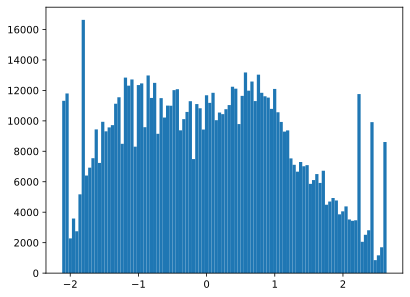

In [6]:
# histogram of the data
plt.hist(X.data.numpy().flatten(), 100)

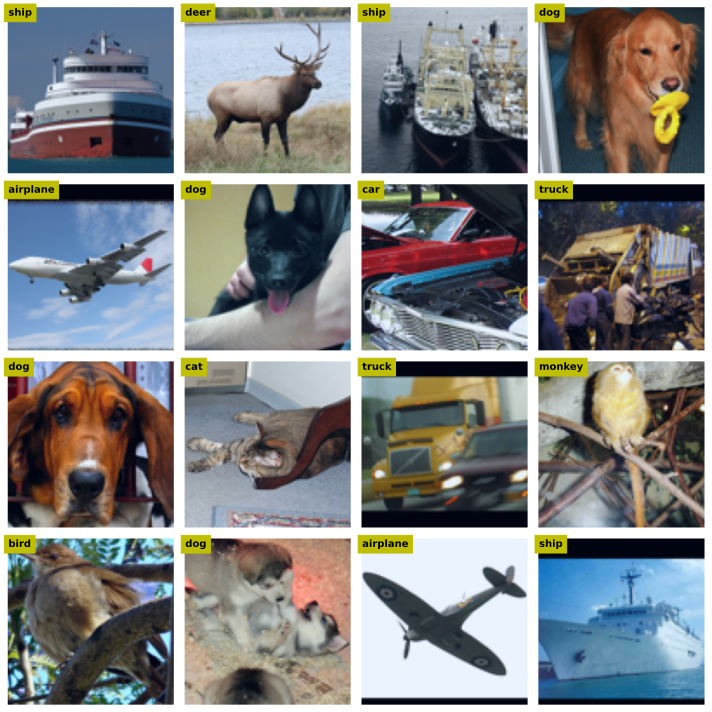

In [7]:
# inspect a few random images

fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 32x32x3)
    pic = X.data[i].numpy().transpose((1, 2, 0))
    pic = pic - np.min(pic)  # undo normalization
    pic = pic / np.max(pic)

    # and its label
    label = trainSet.classes[y[i]]

    # and show!
    ax.imshow(pic)
    ax.text(
        0,
        0,
        label,
        ha="left",
        va="top",
        fontweight="bold",
        color="k",
        backgroundcolor="y",
    )
    ax.axis("off")

plt.tight_layout()
plt.show()

In [44]:
# Import ResNet18 model
weights = tv.models.ResNet18_Weights.DEFAULT
resnet = tv.models.resnet18(weights=weights)

In [45]:
# Summery for param sizes
summary(resnet.to(device), (3, 96, 96))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 48, 48]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 48, 48]          128
├─ReLU: 1-3                              [-1, 64, 48, 48]          --
├─MaxPool2d: 1-4                         [-1, 64, 24, 24]          --
├─Sequential: 1-5                        [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-1                   [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 24, 24]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 24, 24]          128
|    |    └─ReLU: 3-3                    [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 24, 24]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 24, 24]          128
|    |    └─ReLU: 3-6                    [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-2                   [-1, 64, 24, 24]          --
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 48, 48]          9,408
├─BatchNorm2d: 1-2                       [-1, 64, 48, 48]          128
├─ReLU: 1-3                              [-1, 64, 48, 48]          --
├─MaxPool2d: 1-4                         [-1, 64, 24, 24]          --
├─Sequential: 1-5                        [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-1                   [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 24, 24]          36,864
|    |    └─BatchNorm2d: 3-2             [-1, 64, 24, 24]          128
|    |    └─ReLU: 3-3                    [-1, 64, 24, 24]          --
|    |    └─Conv2d: 3-4                  [-1, 64, 24, 24]          36,864
|    |    └─BatchNorm2d: 3-5             [-1, 64, 24, 24]          128
|    |    └─ReLU: 3-6                    [-1, 64, 24, 24]          --
|    └─BasicBlock: 2-2                   [-1, 64, 24, 24]          --
|

In [46]:
# Summery for number of parameters
summary(resnet)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [47]:
# # Freeze the layers
# for p in resnet.parameters():
#     p.requires_grad = False

In [48]:
resnet.fc = nn.Linear(512, 10, bias=True)
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
# Loss Function and opt
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.0001)

In [50]:
# Train the model
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss = torch.zeros(numepochs)
trainAcc = torch.zeros(numepochs)
testAcc = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

    # loop over training data batches
    resnet.train()  # switch to train mode
    batchLoss = []
    batchAcc = []
    for X, y in train_loader:

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        yHat = resnet(X)
        loss = lossfun(yHat, y)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi] = 100 * np.mean(batchAcc)

    #### test performance (here done in batches!)
    resnet.eval()  # switch to test mode
    batchAcc = []
    batchLoss = []
    for X, y in test_loader:

        # push data to GPU
        X = X.to(device)
        y = y.to(device)

        # forward pass and loss
        with torch.no_grad():
            yHat = resnet(X)
            loss = lossfun(yHat, y)

        # loss and accuracy from this batch
        batchLoss.append(loss.item())
        batchAcc.append(torch.mean((torch.argmax(yHat, axis=1) == y).float()).item())
    # end of batch loop...

    # and get average losses and accuracies across the batches
    testLoss[epochi] = np.mean(batchLoss)
    testAcc[epochi] = 100 * np.mean(batchAcc)

    # print out a status update
    print(
        f"Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%"
    )

Finished epoch 1/10. Test accuracy = 88.02%
Finished epoch 2/10. Test accuracy = 88.55%
Finished epoch 3/10. Test accuracy = 88.96%
Finished epoch 4/10. Test accuracy = 89.60%
Finished epoch 5/10. Test accuracy = 89.62%
Finished epoch 6/10. Test accuracy = 88.96%
Finished epoch 7/10. Test accuracy = 87.87%
Finished epoch 8/10. Test accuracy = 86.23%
Finished epoch 9/10. Test accuracy = 87.62%
Finished epoch 10/10. Test accuracy = 87.54%


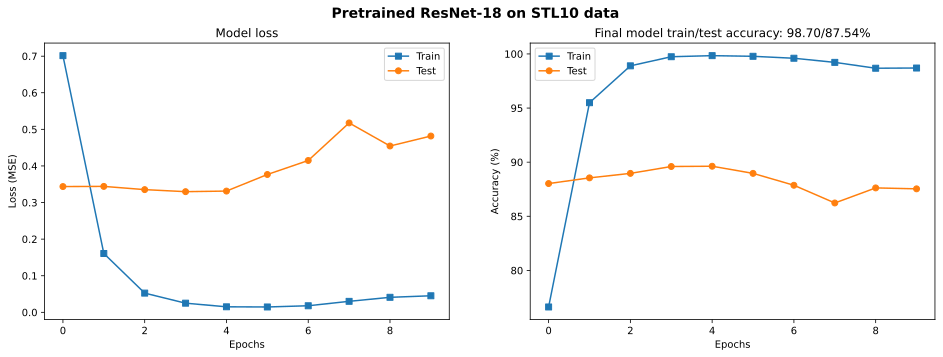

In [51]:
# Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss.cpu(), "s-", label="Train")
ax[0].plot(testLoss.cpu(), "o-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_title("Model loss")
ax[0].legend()

ax[1].plot(trainAcc.cpu(), "s-", label="Train")
ax[1].plot(testAcc.cpu(), "o-", label="Test")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(
    f"Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%"
)
ax[1].legend()

plt.suptitle("Pretrained ResNet-18 on STL10 data", fontweight="bold", fontsize=14)
plt.show()

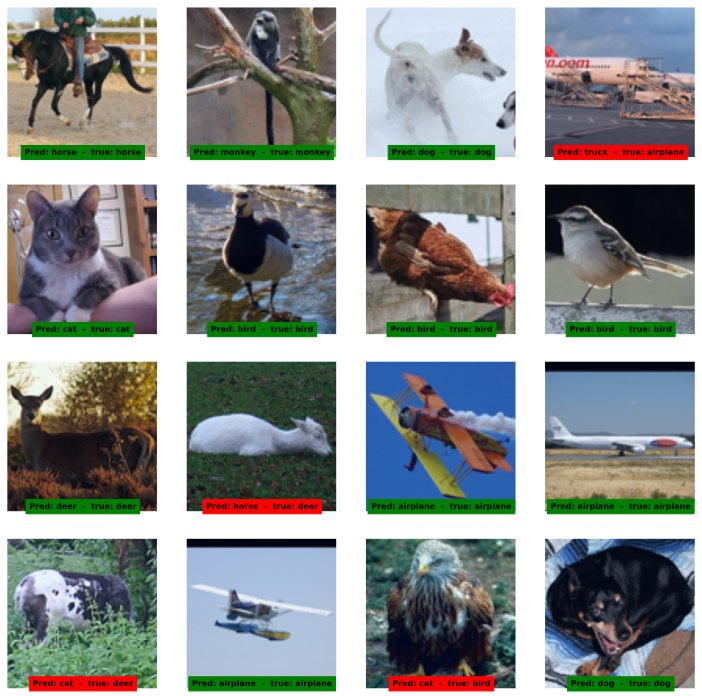

In [52]:
# inspect a few random images

X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)
resnet.eval()
predictions = torch.argmax(resnet(X), axis=1)


fig, axs = plt.subplots(4, 4, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):

    # extract that image (need to transpose it back to 96x96x3)
    pic = X.data[i].cpu().numpy().transpose((1, 2, 0))
    pic = pic - np.min(pic)  # undo normalization
    pic = pic / np.max(pic)

    # show the image
    ax.imshow(pic)

    # label and true class
    label = trainSet.classes[predictions[i]]
    truec = trainSet.classes[y[i]]
    title = f"Pred: {label}  -  true: {truec}"

    # set the title with color-coded accuracy
    titlecolor = "g" if truec == label else "r"
    ax.text(
        48,
        90,
        title,
        ha="center",
        va="top",
        fontweight="bold",
        color="k",
        backgroundcolor=titlecolor,
        fontsize=8,
    )
    ax.axis("off")

plt.tight_layout()
plt.show()